# PCB component definition from CSV file and model image exports

This example shows how to create different types of blocks and assign power
and material to them using a CSV input file

Keywords: **Icepak**, **boundaries**, **PyVista**, **CSV**, **PCB**, **components**.

## Perform imports and define constants

In [1]:
import csv
import os
import tempfile
import time
from pathlib import Path

import ansys.aedt.core
from ansys.aedt.core.examples.downloads import download_file
import matplotlib as mpl
import numpy as np
import pyvista as pv
from IPython.display import Image
from matplotlib import cm
from matplotlib import pyplot as plt

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NG_MODE = False  # Open AEDT UI when it is launched.

## Download and open project

Download the project and open it in non-graphical mode, using a temporary folder.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
project_name = os.path.join(temp_folder.name, "Icepak_CSV_Import.aedt")
ipk = ansys.aedt.core.Icepak(
    project=project_name,
    version=AEDT_VERSION,
    new_desktop=True,
    non_graphical=NG_MODE,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_b37db3cf-d154-4897-a360-5112de09868e.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 4452.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project Icepak_CSV_Import has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Icepak_XI7' of type Icepak.


PyAEDT INFO: Aedt Objects correctly read


Create the PCB as a simple block with lumped material properties.

In [4]:
board = ipk.modeler.create_box(
    origin=[-30.48, -27.305, 0],
    sizes=[146.685, 71.755, 0.4064],
    name="board_outline",
    material="FR-4_Ref",
)

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


## Create components from CSV file

Components are represented as simple cubes with dimensions and properties specified in a CSV file.

In [5]:
filename = download_file(
    "icepak", "blocks-list.csv", local_path=temp_folder.name
)

The CSV file lists block properties:

- Type (solid, network, hollow)
- Name
- Dtart point (xs, ys, zs) and end point (xd, yd, zd)
- Material properties (for solid blocks)
- Power assignment
- Resistances to the board and to the case (for network blocks)
- Whether to add a monitor point to the block (0 or 1)

The following table does not show entire rows and dat. It provides only a sample.


| block_type | name | xs     | ys     | zs   | xd    | yd    | zd   | matname          | power | Rjb | Rjc | Monitor_point |
|------------|------|--------|--------|------|-------|-------|------|------------------|-------|-----|-----|---------------|
| hollow     | R8   | 31.75  | -20.32 | 0.40 | 15.24 | 2.54  | 2.54 |                  | 1     |     |     | 0             |
| solid      | U1   | 16.55  | 10.20  | 0.40 | 10.16 | 20.32 | 5.08 | Ceramic_material | 0.2   |     |     | 1             |
| solid      | U2   | -51    | 10.16  | 0.40 | 10.16 | 27.94 | 5.08 | Ceramic_material | 0.1   |     |     | 1             |
| network    | C180 | 47.62  | 19.05  | 0.40 | 3.81  | 2.54  | 2.43 |                  | 1.13  | 2   | 3   | 0             |
| network    | C10  | 65.40  | -1.27  | 0.40 | 3.81  | 2.54  | 2.43 |                  | 0.562 | 2   | 3   | 0             |
| network    | C20  | 113.03 | -0.63  | 0.40 | 2.54  | 3.81  | 2.43 |                  | 0.445 | 2   | 3   | 0             |

The following code loops over each line of the CSV file, creating solid blocks
and assigning boundary conditions.

Every row of the CSV file has information on a particular block.

In [6]:
with open(filename, "r") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        origin = [
            float(row["xs"]),
            float(row["ys"]),
            float(row["zs"]),
        ]  # block starting point
        dimensions = [
            float(row["xd"]),
            float(row["yd"]),
            float(row["zd"]),
        ]  # block lengths in 3 dimensions
        block_name = row["name"]  # block name

        # Define material name
        if row["matname"]:
            material_name = row["matname"]
        else:
            material_name = "copper"

        # Creates the block with the given name, coordinates, material, and type
        block = ipk.modeler.create_box(
            origin=origin, sizes=dimensions, name=block_name, material=material_name
        )

        # Assign boundary conditions
        if row["block_type"] == "solid":
            ipk.assign_solid_block(
                object_name=block_name,
                power_assignment=row["power"] + "W",
                boundary_name=block_name,
            )
        elif row["block_type"] == "network":
            ipk.create_two_resistor_network_block(
                object_name=block_name,
                pcb=board.name,
                power=row["power"] + "W",
                rjb=row["Rjb"],
                rjc=row["Rjc"],
            )
        else:
            ipk.modeler[block.name].solve_inside = False
            ipk.assign_hollow_block(
                object_name=block_name,
                assignment_type="Total Power",
                assignment_value=row["power"] + "W",
                boundary_name=block_name,
            )

        # Create temperature monitor points if assigned value is 1 in the last
        # column of the CSV file
        if row["Monitor_point"] == "1":
            ipk.monitor.assign_point_monitor_in_object(
                name=row["name"],
                monitor_quantity="Temperature",
                monitor_name=row["name"],
            )

PyAEDT INFO: Boundary Block R8 has been created.


PyAEDT INFO: Boundary Network C1 has been created.


PyAEDT INFO: Boundary Network C2 has been created.


PyAEDT INFO: Boundary Network C3 has been created.


PyAEDT INFO: Boundary Network C8 has been created.


PyAEDT INFO: Boundary Network C22 has been created.


PyAEDT INFO: Boundary Network C23 has been created.


PyAEDT INFO: Boundary Network C24 has been created.


PyAEDT INFO: Boundary Network C25 has been created.


PyAEDT INFO: Boundary Network C26 has been created.


PyAEDT INFO: Boundary Network C27 has been created.


PyAEDT INFO: Boundary Network C28 has been created.


PyAEDT INFO: Boundary Network C29 has been created.


PyAEDT INFO: Boundary Network C30 has been created.


PyAEDT INFO: Boundary Network C4 has been created.


PyAEDT INFO: Boundary Network C5 has been created.


PyAEDT INFO: Boundary Network C6 has been created.


PyAEDT INFO: Boundary Network C7 has been created.


PyAEDT INFO: Boundary Block R10 has been created.


PyAEDT INFO: Boundary Block R13 has been created.


PyAEDT INFO: Boundary Block R90 has been created.


PyAEDT INFO: Boundary Block U1 has been created.


PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmpr6xyjdqs.ansys\Icepak_CSV_Import.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmpr6xyjdqs.ansys\Icepak_CSV_Import.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.01587200164794922


PyAEDT INFO: Boundary Block U2 has been created.


PyAEDT INFO: Boundary Block U3 has been created.


PyAEDT INFO: Boundary Block U15 has been created.


PyAEDT INFO: Boundary Block U4 has been created.


PyAEDT INFO: Boundary Block U16 has been created.


PyAEDT INFO: Boundary Block U5 has been created.


PyAEDT INFO: Boundary Block U6 has been created.


PyAEDT INFO: Boundary Block U7 has been created.


PyAEDT INFO: Boundary Block U8 has been created.


PyAEDT INFO: Boundary Block U9 has been created.


PyAEDT INFO: Boundary Block U11 has been created.


PyAEDT INFO: Boundary Block U12 has been created.


PyAEDT INFO: Boundary Block U13 has been created.


PyAEDT INFO: Boundary Block U14 has been created.


PyAEDT INFO: Boundary Network C9 has been created.


PyAEDT INFO: Boundary Network C16 has been created.


PyAEDT INFO: Boundary Network C17 has been created.


PyAEDT INFO: Boundary Network C19 has been created.


PyAEDT INFO: Boundary Network C21 has been created.


PyAEDT INFO: Boundary Network C180 has been created.


PyAEDT INFO: Boundary Network C10 has been created.


PyAEDT INFO: Boundary Network C20 has been created.


PyAEDT INFO: Boundary Network C11 has been created.


PyAEDT INFO: Boundary Network C12 has been created.


PyAEDT INFO: Boundary Network C13 has been created.


PyAEDT INFO: Boundary Network C14 has been created.


PyAEDT INFO: Boundary Network C15 has been created.


PyAEDT INFO: Boundary Block D1 has been created.


PyAEDT INFO: Boundary Block D2 has been created.


PyAEDT INFO: Boundary Block D3 has been created.


PyAEDT INFO: Boundary Block D4 has been created.


PyAEDT INFO: Boundary Block MP1 has been created.


PyAEDT INFO: Boundary Block R1 has been created.


PyAEDT INFO: Boundary Block R2 has been created.


PyAEDT INFO: Boundary Block R3 has been created.


PyAEDT INFO: Boundary Block R4 has been created.


PyAEDT INFO: Boundary Block R5 has been created.


PyAEDT INFO: Boundary Block R7 has been created.


PyAEDT INFO: Boundary Block R12 has been created.


## Calculate the power assigned to all components

In [7]:
power_budget, total_power = ipk.post.power_budget(units="W")

PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: The power of R8 is 1.0 W


PyAEDT INFO: The power of R10 is 1.25 W


PyAEDT INFO: The power of R13 is 0.75 W


PyAEDT INFO: The power of R90 is 1.1 W


PyAEDT INFO: The power of U1 is 0.2 W


PyAEDT INFO: The power of U2 is 0.1 W


PyAEDT INFO: The power of U3 is 0.05 W


PyAEDT INFO: The power of U15 is 0.25 W


PyAEDT INFO: The power of U4 is 0.15 W


PyAEDT INFO: The power of U16 is 0.18 W


PyAEDT INFO: The power of U5 is 0.175 W


PyAEDT INFO: The power of U6 is 0.3 W


PyAEDT INFO: The power of U7 is 0.3 W


PyAEDT INFO: The power of U8 is 0.3 W


PyAEDT INFO: The power of U9 is 0.3 W


PyAEDT INFO: The power of U11 is 0.3 W


PyAEDT INFO: The power of U12 is 0.3 W


PyAEDT INFO: The power of U13 is 0.3 W


PyAEDT INFO: The power of U14 is 0.3 W


PyAEDT INFO: The power of D1 is 0.183 W


PyAEDT INFO: The power of D2 is 0.705 W


PyAEDT INFO: The power of D3 is 0.875 W


PyAEDT INFO: The power of D4 is 0.951 W


PyAEDT INFO: The power of MP1 is 3.0 W


PyAEDT INFO: The power of R1 is 1.0 W


PyAEDT INFO: The power of R2 is 1.0 W


PyAEDT INFO: The power of R3 is 1.0 W


PyAEDT INFO: The power of R4 is 1.0 W


PyAEDT INFO: The power of R5 is 1.0 W


PyAEDT INFO: The power of R7 is 1.0 W


PyAEDT INFO: The power of R12 is 1.0 W


PyAEDT INFO: The total power is 20.319 W


## Plot model using AEDT

Set the colormap to use. You can use the previously computed power budget to set the minimum and maximum values.

In [8]:
cmap = plt.get_cmap("plasma")
norm = mpl.colors.Normalize(
    vmin=min(power_budget.values()), vmax=max(power_budget.values())
)
scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)

In [9]:
# Color the objects depending
for obj in ipk.modeler.objects.values():
    if obj.name in power_budget:
        obj.color = [
            int(i * 255) for i in scalarMap.to_rgba(power_budget[obj.name])[0:3]
        ]
        obj.transparency = 0
    else:
        obj.color = [0, 0, 0]
        obj.transparency = 0.9

PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Refreshing bodies from Object Info


PyAEDT INFO: Bodies Info Refreshed Elapsed time: 0m 0sec


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


Export the model image by creating a list of all objects that excludes ``Region``.
This list is then passed to the `export_model_picture()` function.
This approach ensures that the exported image is fitted to the PCB and its components.

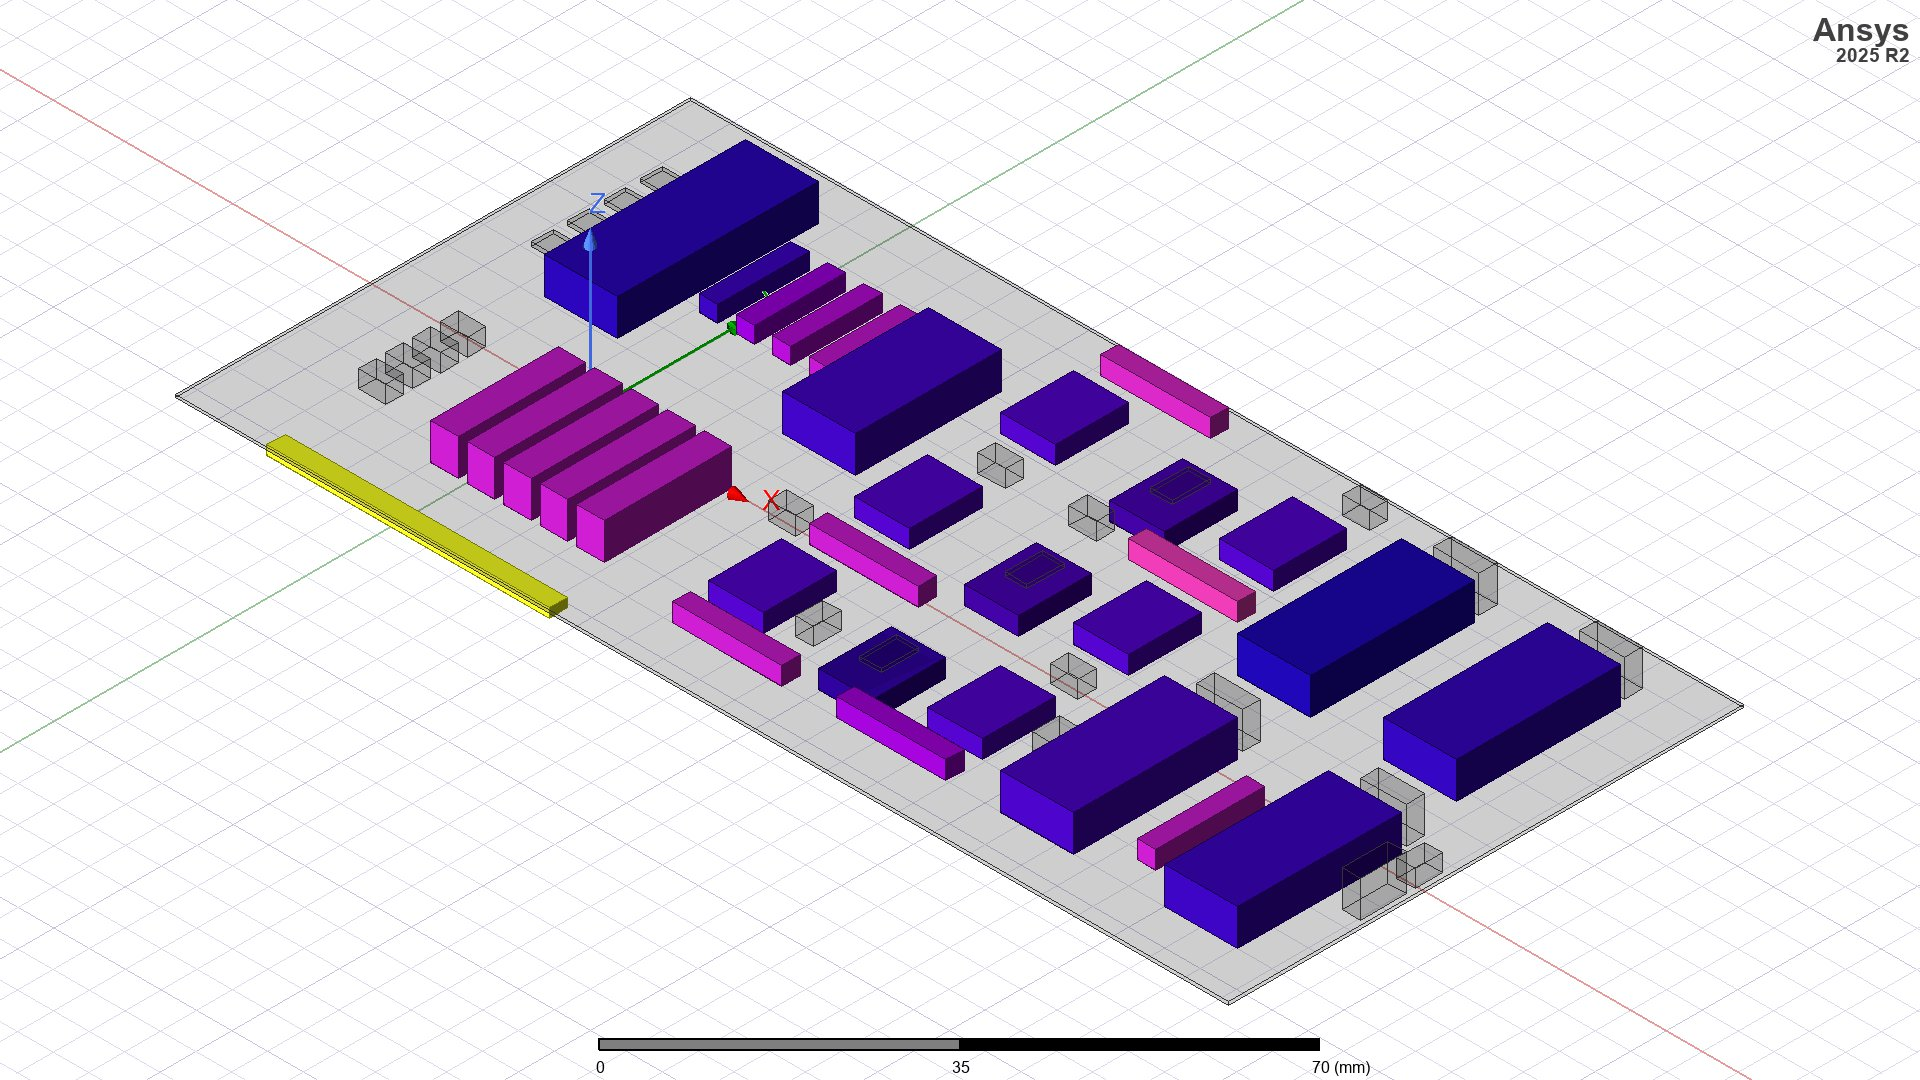

In [10]:
obj_list_noregion = list(ipk.modeler.object_names)
obj_list_noregion.remove("Region")
export_file = os.path.join(temp_folder.name, "object_power_AEDTExport.jpg")
ipk.post.export_model_picture(
    export_file, selections=obj_list_noregion, width=1920, height=1080
)
Image(export_file)

In [11]:
# ### Plot model using PyAEDT
#
# Initialize a PyVista plotter
plotter = pv.Plotter(off_screen=True, window_size=[2048, 1536])

Export all models objects to OBJ files.

In [12]:
f = ipk.post.export_model_obj(
    export_path=temp_folder.name, export_as_multiple_objects=True, air_objects=False
)

Add objects to the PyVista plotter. These objects are either set to a black color or assigned scalar values,
allowing them to be visualized with a colormap.

In [13]:
for file, color, opacity in f:
    if color == (0, 0, 0):
        plotter.add_mesh(mesh=pv.read(file), color="black", opacity=opacity)
    else:
        mesh = pv.read(filename=file)
        mesh["Power"] = np.full(
            shape=mesh.n_points, fill_value=power_budget[Path(file).stem]
        )
        plotter.add_mesh(mesh=mesh, scalars="Power", cmap="viridis", opacity=opacity)

Add a label to the object with the maximum temperature.

In [14]:
max_pow_obj = "MP1"
plotter.add_point_labels(
    points=[ipk.modeler[max_pow_obj].top_face_z.center],
    labels=[f"{max_pow_obj}, {power_budget[max_pow_obj]}W"],
    point_size=20,
    font_size=30,
    text_color="red",
)

<vtkmodules.vtkRenderingCore.vtkActor2D(0x0000026CC0919850) at 0x0000026CC3E529E0>

Export the file.

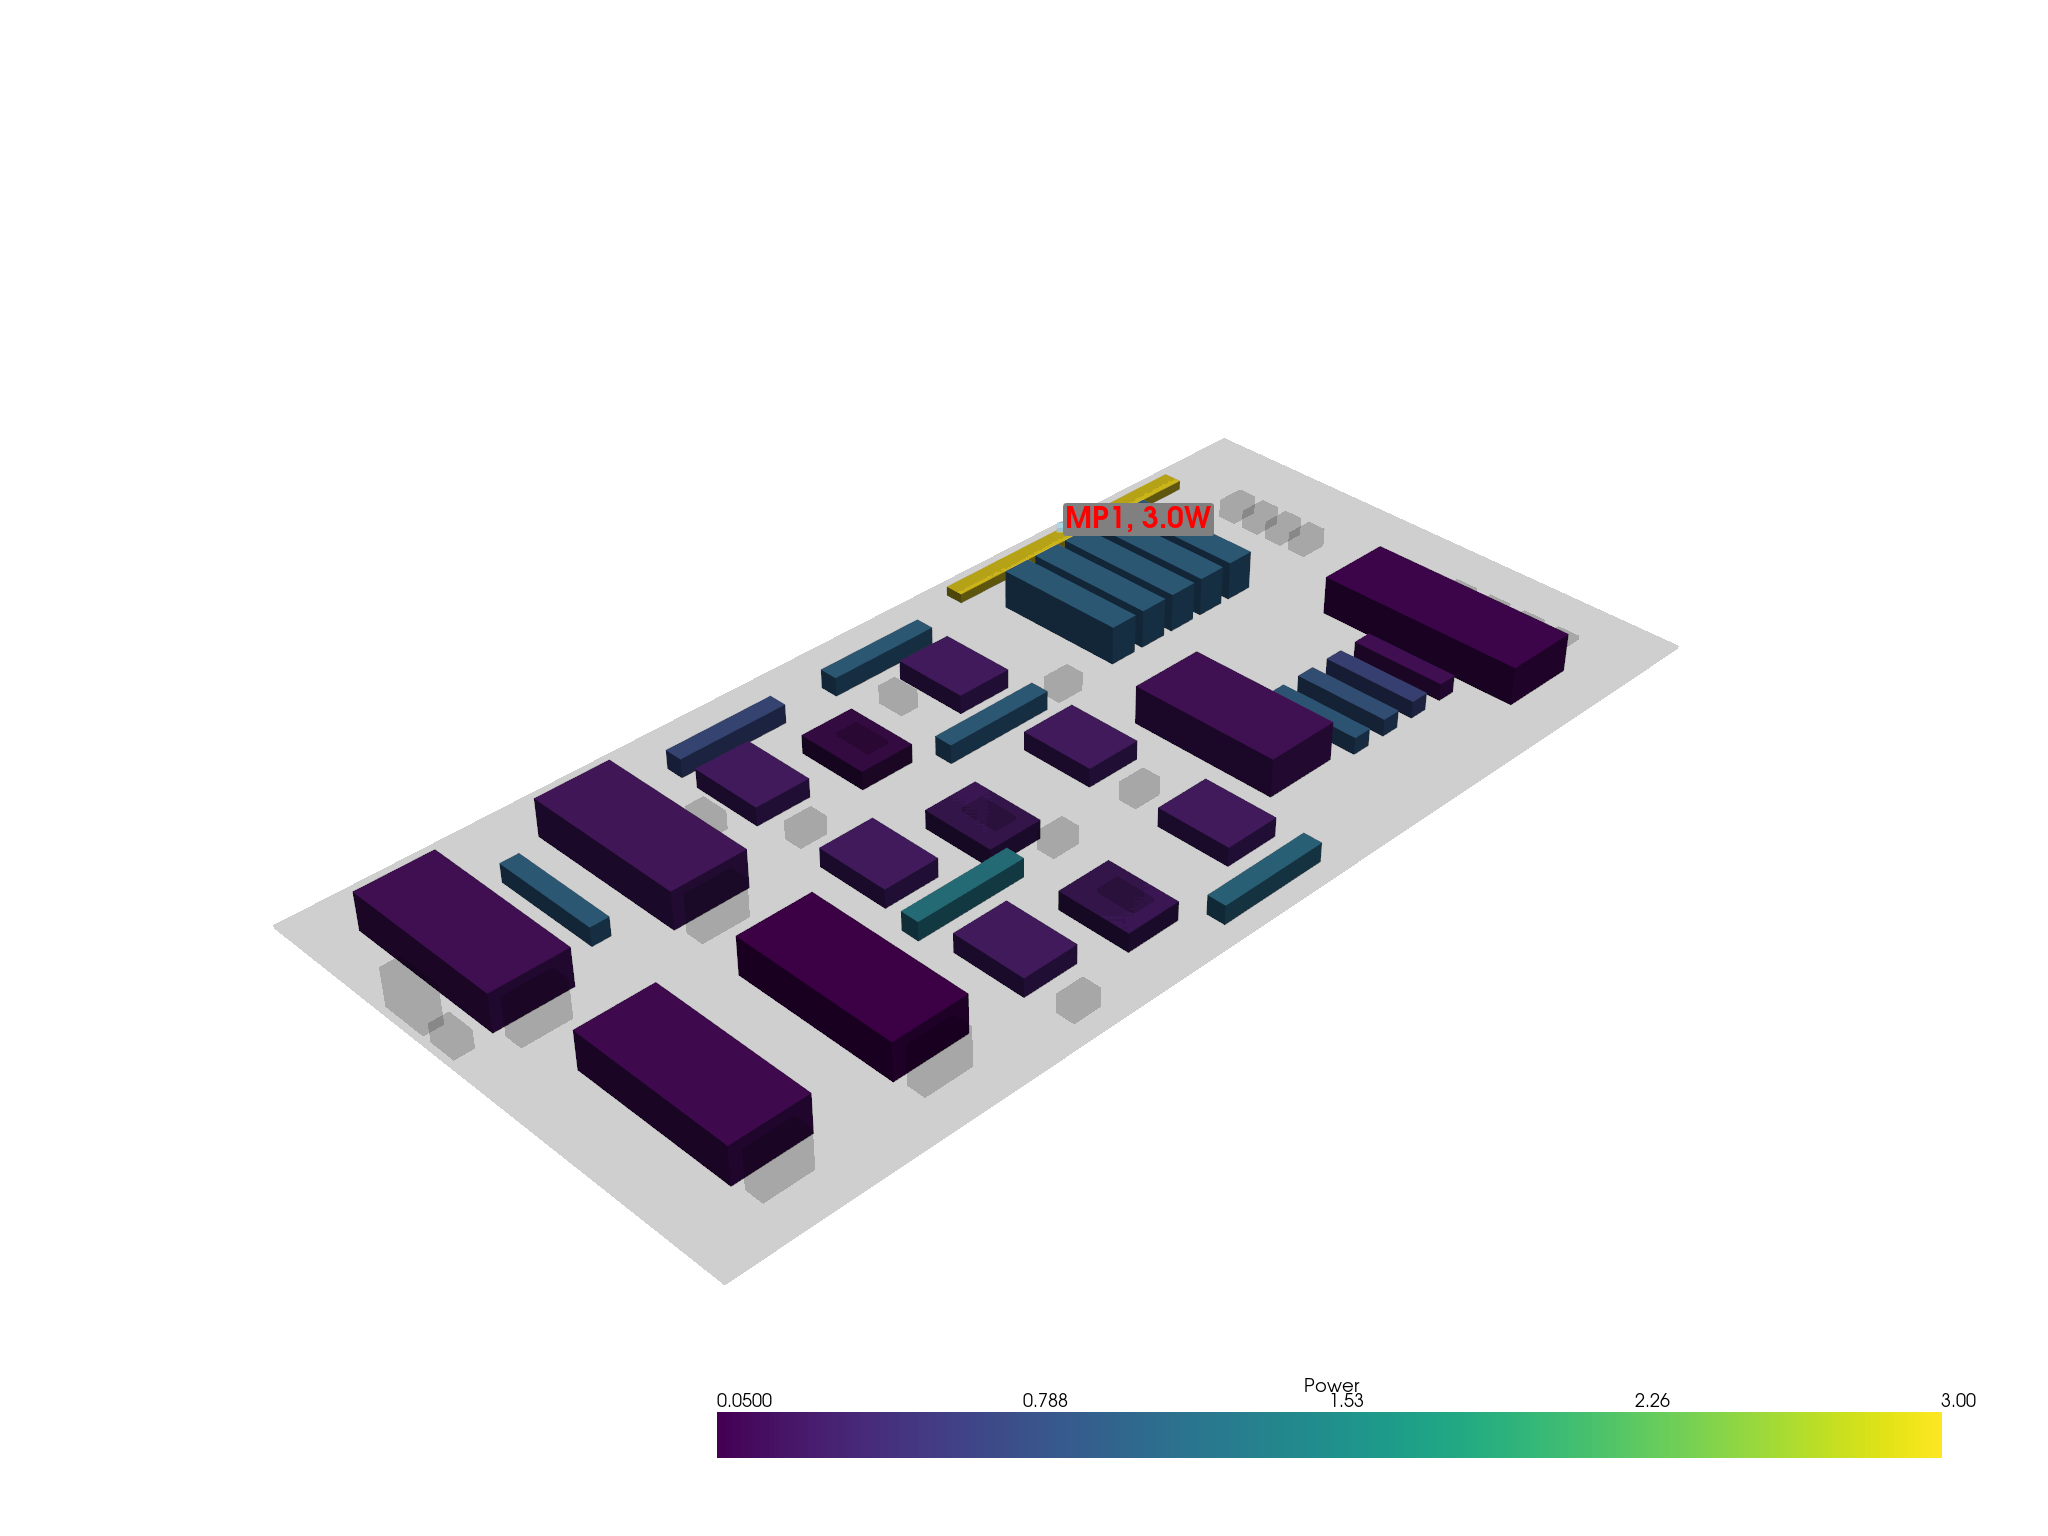

In [15]:
export_file = os.path.join(temp_folder.name, "object_power_pyVista.png")
plotter.screenshot(filename=export_file, scale=1)
Image(export_file)

## Release AEDT

In [16]:
ipk.save_project()
ipk.release_desktop()
time.sleep(
    3
)  # Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.

PyAEDT INFO: Project Icepak_CSV_Import Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [17]:
temp_folder.cleanup()